Licensed under the MIT License.

Copyright (c) 2021-2031. All rights reserved.


# Past Methods for Time Series Analysis

* Time series decomposing
* Stationary check
* Forecastability check
* Cointegration Test
* Granger Casuality

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests

import warnings
warnings.filterwarnings("ignore")

In [2]:
ts_df = pd.read_pickle('../crystal_ball/data_collector/structured_data/sales_ts.pkl')
print(ts_df.shape)

ts_df.head()

(942, 1)


,Daily_Sales
Date,
2013-01-01,58165
2013-01-02,4822042
2013-01-03,4415571
2013-01-04,4587035
2013-01-05,4078281


In [3]:
ts_df_train = ts_df.iloc[ts_df.index < '2015-03-01']
print(ts_df_train.shape)

(789, 1)


## Time Series Decomposing

* Additive Model
* Multiplicative Model

In [4]:
def decompost_ts(ts_col, model='additive'):
    decomposition = seasonal_decompose(ts_col, model=model)
    trend = decomposition.trend
    seasonality = decomposition.seasonal
    residual = decomposition.resid
    
    return trend, seasonality, residual


def plot_decomposed_ts(title, ts_col, trend, seasonality, residual):    
    plt.figure(figsize=(20,10))
    plt.subplot(411)
    plt.plot(ts_col, label='Original', color='blue')
    plt.title(f'{title}')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='r')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonality,label='Seasonality', color='g')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='purple')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

### Additive Model Decomposing

* Additive Method: `Y[t] = T[t] + S[t] + e[t]`

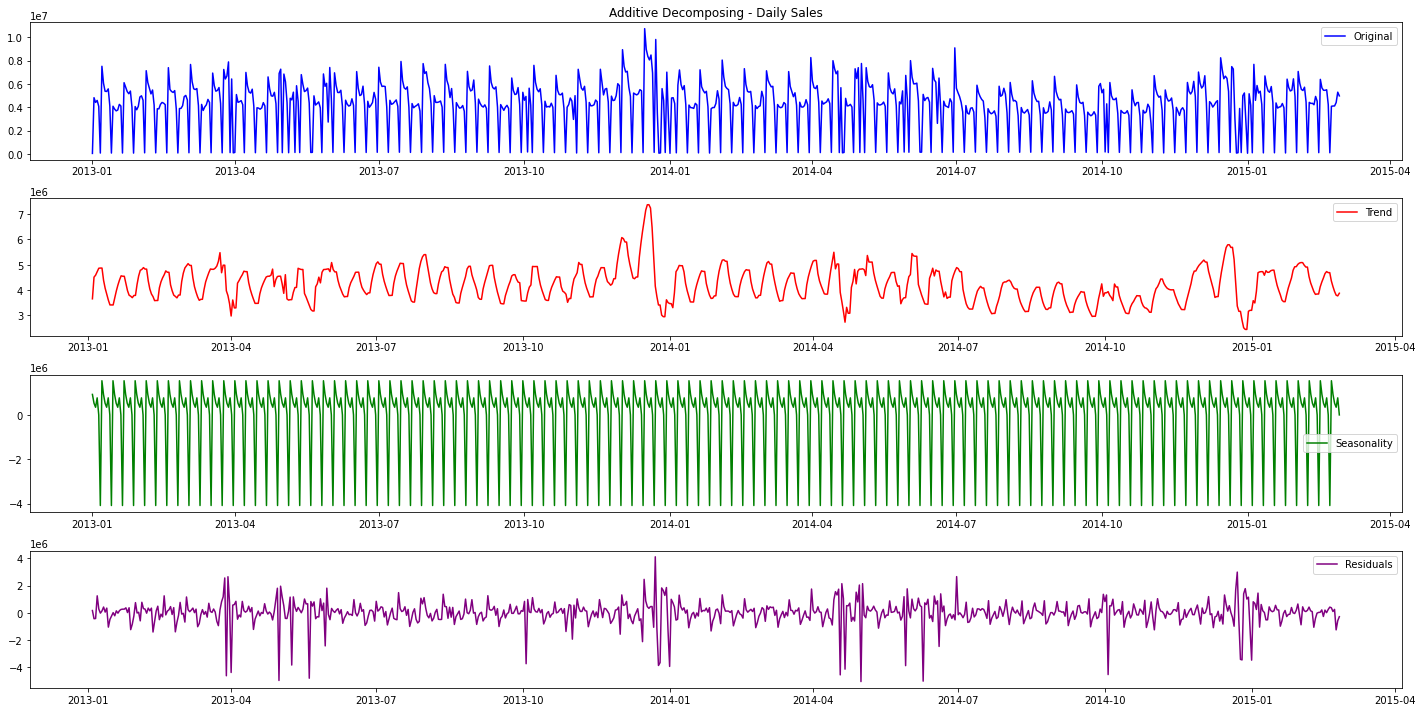

In [13]:
add_trend, add_seasonality, add_residual = decompost_ts(ts_df_train, model='additive')
plot_decomposed_ts('Additive Decomposing - Daily Sales', ts_df_train, add_trend, add_seasonality, add_residual)

### Multiplicative Model Decomposing

* Miltiplicative Method: `Y[t] = T[t] * S[t] * e[t]`

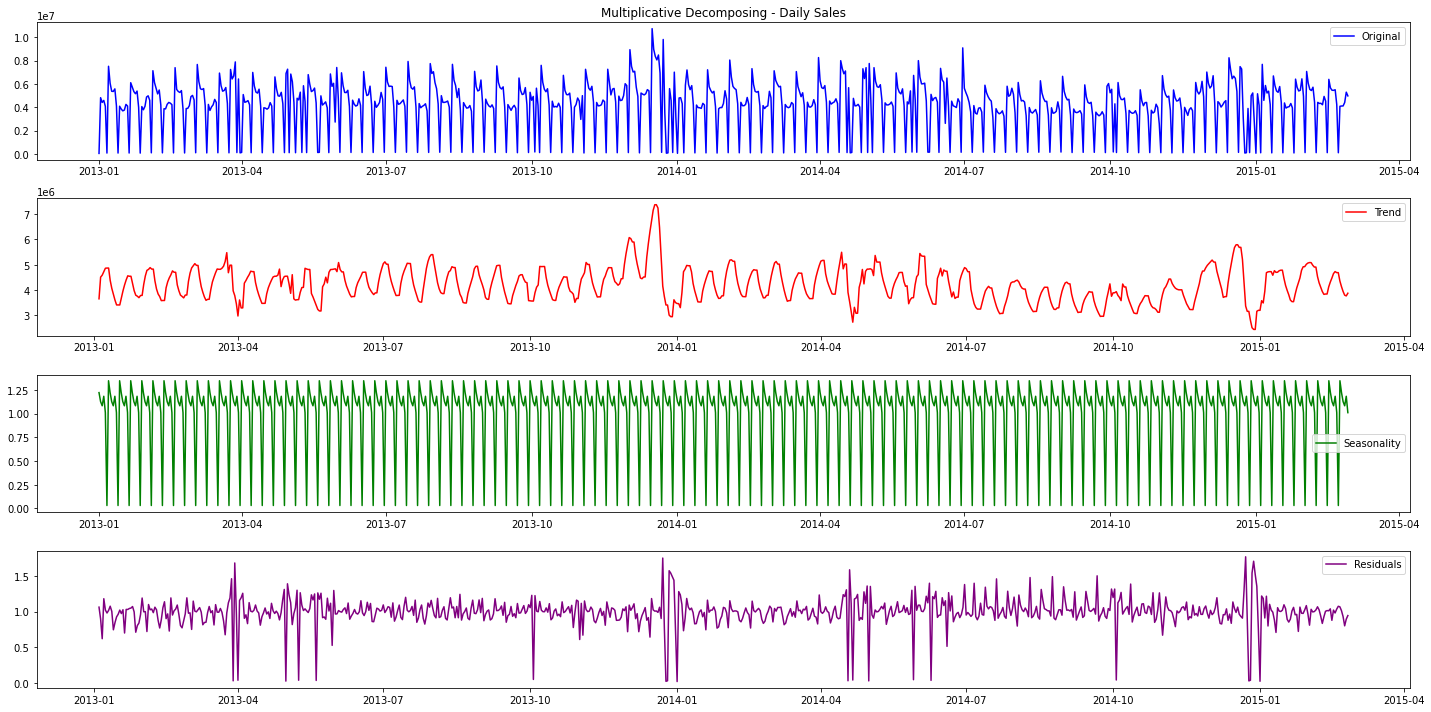

In [14]:
mul_trend, mul_seasonality, mul_residual = decompost_ts(ts_df_train, model='multiplicative')
plot_decomposed_ts('Multiplicative Decomposing - Daily Sales', ts_df_train, mul_trend, mul_seasonality, mul_residual)

## Stationary Analysis

* Stationary test on original ts
* Stationary test on residuals of additive & multiplicative models

In [5]:
def test_stationarity(timeseries, subtitle, window_size=10):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size,center=False).mean()
    rolstd = timeseries.rolling(window=window_size,center=False).std()
    rolcov = timeseries.rolling(window=window_size,center=False).cov()

    # Plot rolling statistics:
    plt.figure(figsize=(20,10))
    orig = plt.plot(timeseries, color='grey',label='Raw ts')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation of {subtitle}')
    plt.show(block=False)
    
    adf_result, kpss_result = None, None
    
    # Perform Augmented Dickey-Fuller test:
    print('Results of Augmented Dickey-Fuller (ADF) Test - Differencing Stationary Test:')
    adftest = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    adf_test_stats = adf_output['Test Statistic']
    for key,value in adftest[4].items():
        adf_output[f'Critical Value {key}'] = value
    print(adf_output)
    print()
    
    # Perform KPSS
    print('Results of KPSS Test - Trending Stationary Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    kpss_test_stats = kpss_output['Test Statistic']
    for key,value in kpsstest[3].items():
        kpss_output[f'Critical Value {key}'] = value
    print(kpss_output)
    print()
    
    if abs(adf_test_stats) >= abs(adf_output[f'Critical Value 1%']):
        adf_result = '99%'
    elif abs(adf_test_stats) >= abs(adf_output[f'Critical Value 5%']) and abs(adf_test_stats) < abs(adf_output[f'Critical Value 1%']):
        adf_result = '95%'
    elif abs(adf_test_stats) >= abs(adf_output[f'Critical Value 10%']) and abs(adf_test_stats) < abs(adf_output[f'Critical Value 5%']):
        adf_result = '90%'
    
    if abs(kpss_test_stats) >= abs(kpss_output['Critical Value 1%']):
        kpss_result = '99%'
    elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 2.5%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 1%']):
        kpss_result = '97.5%'
    elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 5%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 2.5%']):
        kpss_result = '95%'
    elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 10%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 5%']):
        kpss_result = '90%'
    
    if adf_result is not None:
        print(f'There is {adf_result} confidence of differencing stationary')
    else:
        print(f'The data is not differencing stationary')
        
    if kpss_result is not None:
        print(f'There is {kpss_result} confidence of trending stationary')
    else:
        print(f'The data is not trending stationary')

### Stationary Test on Raw Time Series

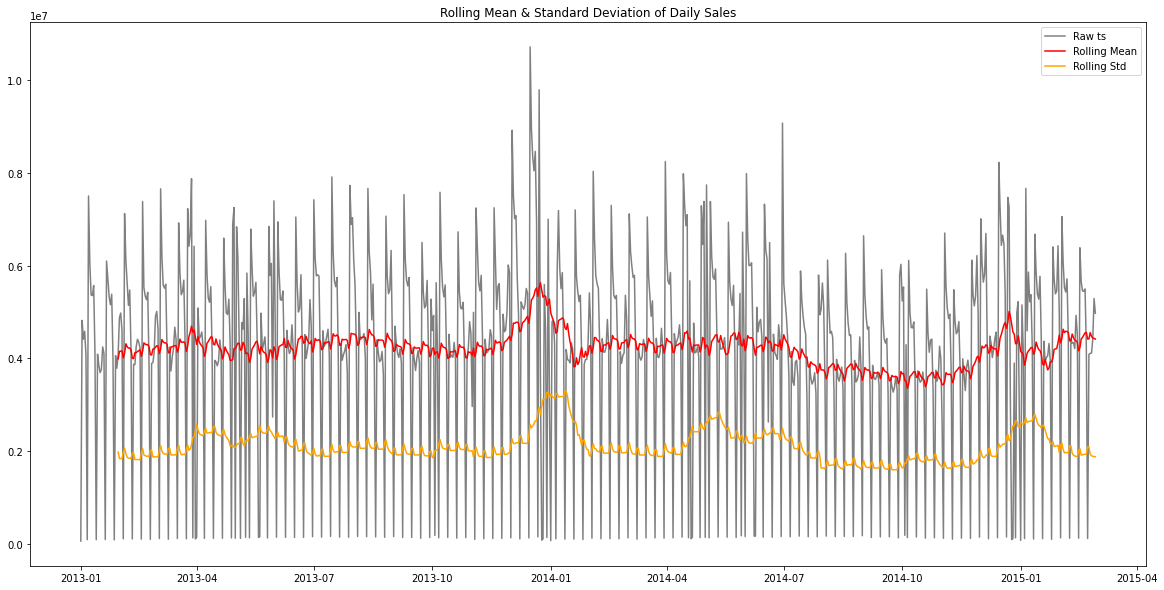

Results of Augmented Dickey-Fuller (ADF) Test - Differencing Stationary Test:
Test Statistic                  -4.387308
p-value                          0.000313
#Lags Used                      20.000000
Number of Observations Used    768.000000
Critical Value 1%               -3.438893
Critical Value 5%               -2.865311
Critical Value 10%              -2.568778
dtype: float64

Results of KPSS Test - Trending Stationary Test:
Test Statistic          0.380510
p-value                 0.085556
Lags Used              21.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64

There is 99% confidence of differencing stationary
There is 90% confidence of trending stationary


In [16]:
test_stationarity(timeseries=ts_df_train, subtitle='Daily Sales', window_size=30)

### Stationary Test on 1st Order Differencing Time Series

* `First Order Differencing = y_i - y_i-1`

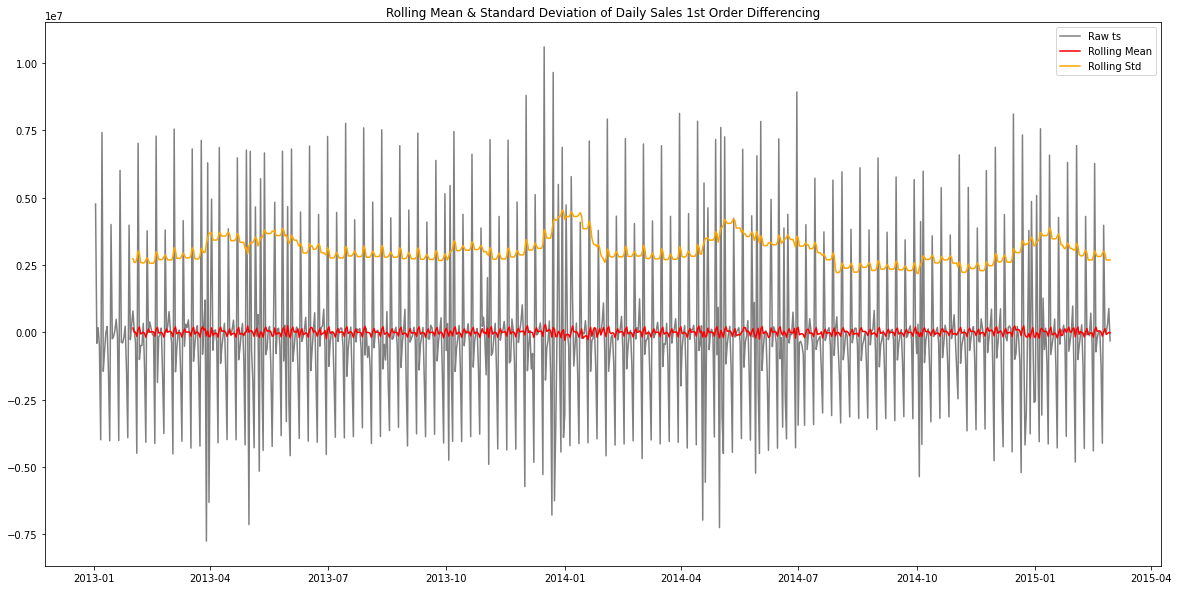

Results of Augmented Dickey-Fuller (ADF) Test - Differencing Stationary Test:
Test Statistic                -1.127697e+01
p-value                        1.488334e-20
#Lags Used                     2.100000e+01
Number of Observations Used    7.660000e+02
Critical Value 1%             -3.438916e+00
Critical Value 5%             -2.865321e+00
Critical Value 10%            -2.568783e+00
dtype: float64

Results of KPSS Test - Trending Stationary Test:
Test Statistic          0.024864
p-value                 0.100000
Lags Used              21.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64

There is 99% confidence of differencing stationary
The data is not trending stationary


In [8]:
ts_df_train_1diff = ts_df_train.diff(1).dropna()
test_stationarity(timeseries=ts_df_train_1diff, subtitle='Daily Sales 1st Order Differencing', window_size=30)

### Stationary Test on 2nd Order Differencing Time Series

* `Second Order Differencing = (y_i - y_i-1) - (y_i-1 - y_i-2) = y_i - 2*y_i-1 + y_i-2`

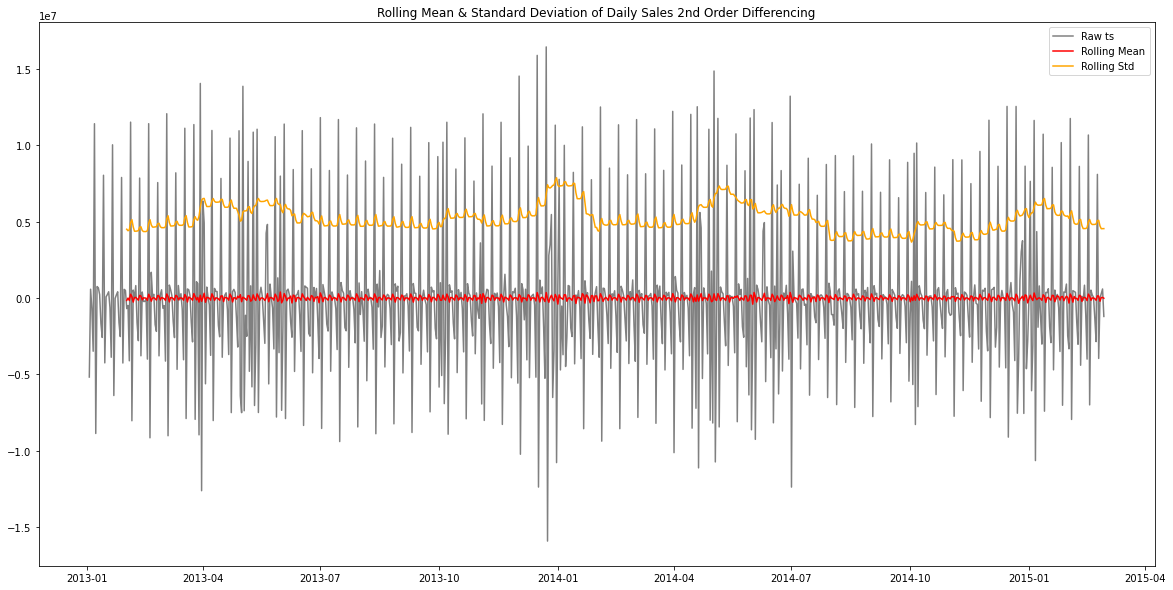

Results of Augmented Dickey-Fuller (ADF) Test - Differencing Stationary Test:
Test Statistic                -1.423327e+01
p-value                        1.583050e-26
#Lags Used                     2.100000e+01
Number of Observations Used    7.650000e+02
Critical Value 1%             -3.438927e+00
Critical Value 5%             -2.865325e+00
Critical Value 10%            -2.568786e+00
dtype: float64

Results of KPSS Test - Trending Stationary Test:
Test Statistic          0.017816
p-value                 0.100000
Lags Used              21.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64

There is 99% confidence of differencing stationary
The data is not trending stationary


In [10]:
ts_df_train_2diff = ts_df_train - 2*ts_df_train.shift(1) + ts_df_train.shift(2)
ts_df_train_2diff.dropna(inplace=True)
test_stationarity(timeseries=ts_df_train_2diff, subtitle='Daily Sales 2nd Order Differencing', window_size=30)

### Additive Model vs Multiplicative Model - Stationary Test on Residuals

* Multiplicative model is better, since its residuals achieved 95% confidence of differencing stationary, and 97.5% confidence of trending stationary

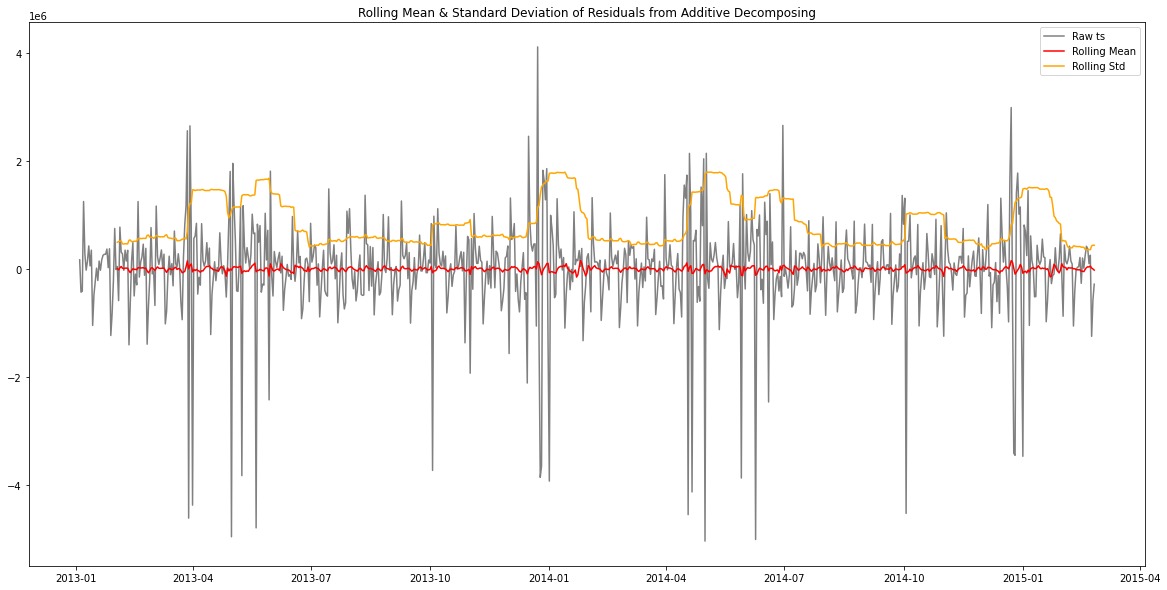

Results of Augmented Dickey-Fuller (ADF) Test - Differencing Stationary Test:
Test Statistic                -1.267137e+01
p-value                        1.242411e-23
#Lags Used                     2.100000e+01
Number of Observations Used    7.610000e+02
Critical Value 1%             -3.438972e+00
Critical Value 5%             -2.865345e+00
Critical Value 10%            -2.568796e+00
dtype: float64

Results of KPSS Test - Trending Stationary Test:
Test Statistic          0.01976
p-value                 0.10000
Lags Used              21.00000
Critical Value 10%      0.34700
Critical Value 5%       0.46300
Critical Value 2.5%     0.57400
Critical Value 1%       0.73900
dtype: float64

There is 99% confidence of differencing stationary
The data is not trending stationary


In [17]:
# test residuals from additive decomposing
add_residual.dropna(inplace=True)
test_stationarity(timeseries=add_residual, subtitle='Residuals from Additive Decomposing', window_size=30)

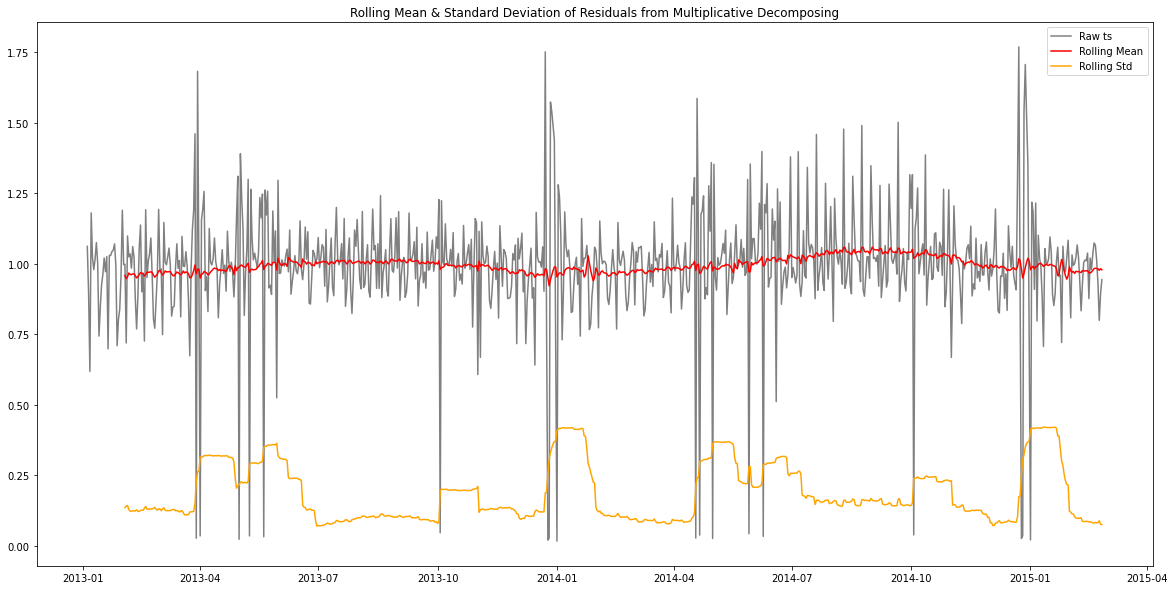

Results of Augmented Dickey-Fuller (ADF) Test - Differencing Stationary Test:
Test Statistic                  -2.668087
p-value                          0.079725
#Lags Used                      20.000000
Number of Observations Used    762.000000
Critical Value 1%               -3.438961
Critical Value 5%               -2.865340
Critical Value 10%              -2.568794
dtype: float64

Results of KPSS Test - Trending Stationary Test:
Test Statistic          0.575634
p-value                 0.024851
Lags Used              21.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64

There is 90% confidence of differencing stationary
There is 97.5% confidence of trending stationary


In [18]:
# test residuals frommultiplicative decomposing
mul_residual.dropna(inplace=True)
test_stationarity(timeseries=mul_residual, subtitle='Residuals from Multiplicative Decomposing', window_size=30)

## Forecastability Analysis

* Approximate Entropy Wiki: https://en.wikipedia.org/wiki/Approximate_entropy
* Sample Entropy Wiki: https://en.wikipedia.org/wiki/Sample_entropy

In [26]:
def approximate_entropy(U, m, r):
    """
    Compute approximate entropy.
    
    U: time series data.
    m: int, the length of compared run of data.
    r: tolerance level, a positive real number, it specifies a filtering level.
    """
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))

    N = len(U)
    return _phi(m) - _phi(m + 1)


def sample_entropy(U, m, r):
    """
    Compute sample entropy.
    
    U: time series data.
    m: int, the length of compared run of data.
    r: tolerance level, a positive real number, it specifies a filtering level.
    """
    N = len(U)
    B = 0.0
    A = 0.0
    
    # Split time series and save all templates of length m
    xmi = np.array([U[i : i + m] for i in range(N - m)])
    xmj = np.array([U[i : i + m] for i in range(N - m + 1)])

    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])

    # Similar for computing A
    m += 1
    xm = np.array([U[i : i + m] for i in range(N - m + 1)])

    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])
    return -np.log(A / B)

In [27]:
ts_type = 'raw'
apx_en_raw = approximate_entropy(ts_df_train.values, m=2, r=0.2*np.std(ts_df_train.values))
smp_en_raw = sample_entropy(ts_df_train.values, m=2, r=0.2*np.std(ts_df_train.values))
print(f'Approximate Entropy of {ts_type} ts is {apx_en_raw}, Sample Entropy of {ts_type} ts is {smp_en_raw}')

Approximate Entropy of raw ts is 0.9079859566552715, Sample Entropy of raw ts is 0.8321557515627397


In [24]:
ts_type = 'multiplicative residuals'
apx_en_mul_res = approximate_entropy(mul_residual.values, m=2, r=0.2*np.std(mul_residual.values))
smp_en_mul_res = sample_entropy(mul_residual.values, m=2, r=0.2*np.std(mul_residual.values))
print(f'Approximate Entropy of {ts_type} ts is {apx_en_mul_res}, Sample Entropy of {ts_type} ts is {smp_en_mul_res}')

Approximate Entropy of multiplicative residuals ts is 1.2065587035611145, Sample Entropy of multiplicative residuals ts is 1.1612717349137036


## Multivariate Time Series Analysis

In [22]:
mul_ts_df = pd.read_pickle('../crystal_ball/data_collector/structured_data/multivar_ts.pkl')

print(mul_ts_df.shape)
mul_ts_df.head()

(8143, 6)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


### Stationary Check

In [3]:
def test_stationarity_multi_ts(multi_ts_df):
    results_dct = {}
    
    for col in multi_ts_df.columns:
        timeseries = multi_ts_df[col]
        
        adf_result, kpss_result = None, None
        results_dct[col] = {'Differencing Stationary': None, 'Trending Stationary': None}
    
        # Perform Augmented Dickey-Fuller test:
        adftest = adfuller(timeseries, autolag='AIC')
        adf_output = pd.Series(adftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        adf_test_stats = adf_output['Test Statistic']
        for key,value in adftest[4].items():
            adf_output[f'Critical Value {key}'] = value
            
        if abs(adf_test_stats) >= abs(adf_output[f'Critical Value 1%']):
            adf_result = '99%'
        elif abs(adf_test_stats) >= abs(adf_output[f'Critical Value 5%']) and abs(adf_test_stats) < abs(adf_output[f'Critical Value 1%']):
            adf_result = '95%'
        elif abs(adf_test_stats) >= abs(adf_output[f'Critical Value 10%']) and abs(adf_test_stats) < abs(adf_output[f'Critical Value 5%']):
            adf_result = '90%'

            
        # Perform KPSS
        kpsstest = kpss(timeseries, regression='c')
        kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
        kpss_test_stats = kpss_output['Test Statistic']
        for key,value in kpsstest[3].items():
            kpss_output[f'Critical Value {key}'] = value

        if abs(kpss_test_stats) >= abs(kpss_output['Critical Value 1%']):
            kpss_result = '99%'
        elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 2.5%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 1%']):
            kpss_result = '97.5%'
        elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 5%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 2.5%']):
            kpss_result = '95%'
        elif abs(kpss_test_stats) >= abs(kpss_output['Critical Value 10%']) and abs(kpss_test_stats) < abs(kpss_output[f'Critical Value 5%']):
            kpss_result = '90%'
    
        results_dct[col]['Differencing Stationary'] = adf_result
        results_dct[col]['Trending Stationary'] = kpss_result
        
    return results_dct

In [4]:
multi_ts_stationary = test_stationarity_multi_ts(mul_ts_df.drop('Occupancy', axis=1))

for k, v in multi_ts_stationary.items():
    print(k)
    print(v)
    print()

Temperature
{'Differencing Stationary': '90%', 'Trending Stationary': '99%'}

Humidity
{'Differencing Stationary': None, 'Trending Stationary': '99%'}

Light
{'Differencing Stationary': '95%', 'Trending Stationary': '99%'}

CO2
{'Differencing Stationary': '99%', 'Trending Stationary': '99%'}

HumidityRatio
{'Differencing Stationary': None, 'Trending Stationary': '99%'}



In [25]:
# Didn't take much effort to convert the data to stationary, so here I stationarized the data before later analysis
mul_ts_df['Humidity'] = mul_ts_df['Humidity'].diff()
mul_ts_df['HumidityRatio'] = mul_ts_df['HumidityRatio'].diff()
mul_ts_df = mul_ts_df.dropna()
print(mul_ts_df.shape)

multi_ts_stationary = test_stationarity_multi_ts(mul_ts_df.drop('Occupancy', axis=1))
for k, v in multi_ts_stationary.items():
    print(k)
    print(v)
    print()

(8142, 6)
Temperature
{'Differencing Stationary': '90%', 'Trending Stationary': '99%'}

Humidity
{'Differencing Stationary': '99%', 'Trending Stationary': '97.5%'}

Light
{'Differencing Stationary': '95%', 'Trending Stationary': '99%'}

CO2
{'Differencing Stationary': '99%', 'Trending Stationary': '99%'}

HumidityRatio
{'Differencing Stationary': '99%', 'Trending Stationary': '97.5%'}



### Cointegration Test

* Reference: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
* It doesn't require each ts in the data to be stationary

In [6]:
def adjust(val, length = 12): 
    """
    Make each printed str to be the same length
    """
    return str(val).ljust(length)


def cointegration_test(df, alpha=0.05, det_order=-1, k_ar_diff=5): 
    cointegrated_cols = []
    
    out = coint_johansen(df, det_order, k_ar_diff)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]

    print(f'Name   ::  Test Stat > C({1-alpha}%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        test_result = trace > cvt
        print(f'{adjust(col, 15)}: {adjust(round(trace, 2), 8)} > {adjust(cvt, 10)} ==> {test_result}')
        
        if test_result:
            cointegrated_cols.append(col)
            
    print()
    if len(cointegrated_cols) >= 2:
        print(f'Columns {cointegrated_cols} are cointegrated')
    else:
        print('The data is not cointegrated')

In [10]:
cointegration_test(mul_ts_df, alpha=0.05)

Name   ::  Test Stat > C(0.95%)    =>   Signif  
 ----------------------------------------
Temperature    : 2862.22  > 83.9383    ==> True
Humidity       : 1576.06  > 60.0627    ==> True
Light          : 472.2    > 40.1749    ==> True
CO2            : 220.53   > 24.2761    ==> True
HumidityRatio  : 7.88     > 12.3212    ==> False
Occupancy      : 0.58     > 4.1296     ==> False

Columns ['Temperature', 'Humidity', 'Light', 'CO2'] are cointegrated


### Granger Causality & Assumed Causality

* Reference1: https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/?utm_source=feedburner&utm_medium=email&utm_campaign=Feed%3A+AnalyticsVidhya+%28Analytics+Vidhya%29
  * This method is to check assumed causality through granger causality
* Reference2: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
  * If only to check granger causality, the matrix used here works
* Options for `test` can be: `ssr_ftest`, `ssr_chi2test`, `lrtest` and `params_ftest`

In [33]:
def remove_highly_correlated_features(data, threshold):
    """
    For feature pairs that are highly correlated, remove one of the feature from each pair.
    :param data: features input, pandas dataframe
    :param threshold: the correlation threshold decides which feature pairs are highly correlated, value between 0..1 range
    """
    corr_matrix = data.corr().abs()  # create correlation matrix
    upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))  # upper triangle
    drop_lst = [column for column in upper_matrix.columns if any(upper_matrix[column] > threshold)]

    return drop_lst


def check_assumed_causality(df, maxlag=5, alpha=0.05, test='ssr_chi2test'):
    gc_results = []
    
    all_cols = df.columns
    
    for i in range(len(all_cols)):
        col1 = all_cols[i]
        for j in range(i+1, len(all_cols)):
            col2 = all_cols[j]
            results1 = grangercausalitytests(df[[col1, col2]], maxlag=maxlag, verbose=False)
            p1 = np.mean([results1[i+1][0][test][1] for i in range(maxlag)])
            results2 = grangercausalitytests(df[[col2, col1]], maxlag=maxlag, verbose=False)
            p2 = np.mean([results2[i+1][0][test][1] for i in range(maxlag)])
            
            if p1 < alpha and p2 >= alpha:
                gc_results.append(f'{col2} causes {col1}')
            elif p1 >= alpha and p2 < alpha:
                gc_results.append(f'{col1} causes {col2}')
    return gc_results

In [28]:
# remove highly correlated columns
drop_lst = remove_highly_correlated_features(mul_ts_df, threshold=0.75)
print(drop_lst)

mul_ts_df = mul_ts_df.drop(drop_lst, axis=1)

['HumidityRatio', 'Occupancy']


In [34]:
gc_results = check_assumed_causality(mul_ts_df, maxlag=3, alpha=0.05, test='ssr_chi2test')
gc_results.sort()
gc_results

['CO2 causes Temperature',
 'Humidity causes CO2',
 'Light causes Humidity',
 'Light causes Temperature',
 'Temperature causes Humidity']